In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Generate random graph with cities and connections for Traveling Salesman Problem

In [2]:
def create_random_cities(n):
    """Returns an array of random cities (points) of given size."""
    cities = []
    for i in range(n):
        cities.append(np.random.rand(2))
    return np.array(cities)

In [3]:
node_count = 50
cities = create_random_cities(node_count)

In [4]:
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)

def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            distance = distance_between_points(cities[i], cities[j])
            matrix[i][j] = distance
            matrix[j][i] = distance
    return matrix

In [5]:
def calculate_cost(cost_matrix, solution):
    """Returns length of the given route"""
    total = 0
    for i in range(node_count):
        total += cost_matrix[i][(i+1)%node_count]
    return total

### Compute QUBO model for Traveling Salesman Problem Hamiltonian

In [6]:
def key(a, b):
    """key returns a key for QUBO dictionary."""
    return a * node_count + b

In [7]:
A = 20
B = 1

def qubo(distances):
    """qubo generates and returns QUBO dictionary with encoded Hamiltonian"""
    q = {}
    for i in range(node_count*node_count):
        for j in range(node_count*node_count):
            q.update({(i, j): 0})

    # Constraint that each row has exactly one 1
    for v in range(node_count):
        for j in range(node_count):
            q[(key(v, j), key(v, j))] += -1*A
            for k in range(j+1, node_count):
                q[(key(v, j), key(v, k))] += 2*A
                q[(key(v, k), key(v, j))] += 2*A

    # Constraint that each column has exactly one 1
    for j in range(node_count):
        for v in range(node_count):
            q[(key(v, j), key(v, j))] += -1*A
            for w in range(v+1, node_count):
                q[(key(v, j), key(w, j))] += 2*A
                q[(key(w, j), key(v, j))] += 2*A

    # Objective that minimizes distance
    for u in range(node_count):
        for v in range(node_count):
            if u != v:
                for j in range(node_count):
                    q[(key(u, j), key(v, (j+1) % node_count))] += B*distances[u][v]

    return q

In [8]:
distance_matrix = get_distance_matrix(cities)
q = qubo(distance_matrix)

### Find route on D-Wave QBSolv simulator

In [9]:
from dwave_qbsolv import QBSolv
dwave_qbsolv_resp = QBSolv().sample_qubo(q)

In [10]:
dwave_qbsolv_sample = next(iter(dwave_qbsolv_resp))

In [11]:
dwave_qbsolv_route = [-1]*(node_count+1)
for node in dwave_qbsolv_sample:
    if dwave_qbsolv_sample[node]>0:
        j = node%node_count
        v = (node-j)/node_count
        dwave_qbsolv_route[j] = int(v)
dwave_qbsolv_route[-1] = dwave_qbsolv_route[0] # Linking the last node to the first one

### Find route on D-Wave Leap Hybrid hardware

In [12]:
from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()
resp = sampler.sample_qubo(q)
dwave_leap_hybrid_sample = next(iter(resp))

In [13]:
dwave_leap_hybrid_route = [-1]*(node_count+1)
for node in dwave_leap_hybrid_sample:
    if dwave_leap_hybrid_sample[node]>0:
        j = node%node_count
        v = (node-j)/node_count
        dwave_leap_hybrid_route[j] = int(v)
dwave_leap_hybrid_route[-1] = dwave_leap_hybrid_route[0] # Linking the last node to the first one

### Plot results

In [14]:
def plot_cities(cities):
    plt.scatter(cities[:, 0], cities[:, 1], s=200, c='blue', alpha=0.1)
    for i, city in enumerate(cities):
        x = city[0]
        y = city[1]
        plt.annotate(i, (x, y), size=8, color='blue', ha='center', va='center')

In [15]:
def plot_solution(cities, solution, title):
    print(title)
    print(f"Route Length: {calculate_cost(get_distance_matrix(cities), solution)}")
    print(solution)
    plt.rcParams['figure.figsize'] = [10, 10]
    plot_cities(cities)
    plt.xlim([min(cities[:, 0]), max(cities[:, 0])])
    plt.ylim([min(cities[:, 1]), max(cities[:, 1])])
    for i in range(len(solution) - 1):
        a = i%len(solution)
        b = (i+1)%len(solution)
        A = solution[a]
        B = solution[b]
        plt.plot([cities[A, 0], cities[B, 0]], [cities[A, 1], cities[B, 1]], c='r')

D-Wave QBSolv Route
Route Length: 27.245919602811234
[10, 37, 40, 6, 25, 2, 28, 31, 39, 36, 12, 44, 15, 4, 48, 0, 47, 7, 19, 34, 21, 26, 49, 1, 43, 8, 14, 29, 22, 17, 41, 11, 30, 27, 24, 35, 5, 45, 42, 23, 46, 18, 33, 3, 9, 16, 38, 20, 32, 13, 10]


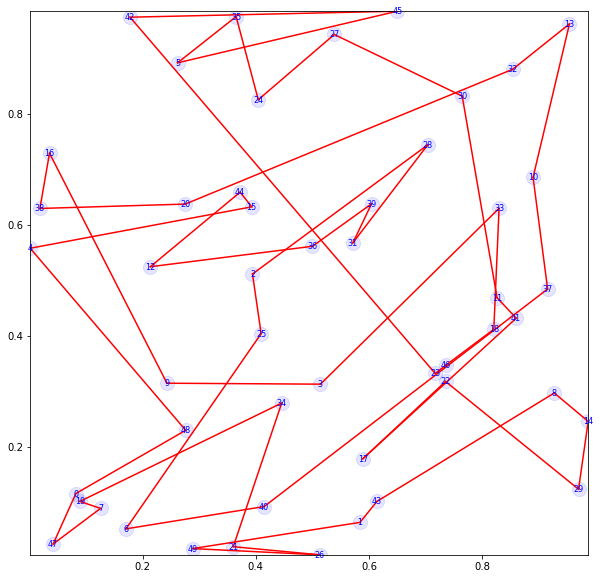

In [16]:
plot_solution(cities, dwave_qbsolv_route, "D-Wave QBSolv Route")

D-Wave Leap Hybrid Route
Route Length: 27.245919602811234
[0, 7, 48, 16, 4, 38, 12, 19, 39, 8, 27, 40, 23, 14, 13, 15, 26, 3, 20, 18, 24, 22, 44, 17, 31, 6, 49, 47, 9, 29, 25, 35, 33, 32, 41, 1, 28, 10, 37, 11, 30, 36, 2, 45, 5, 21, 43, 34, 46, 42, 0]


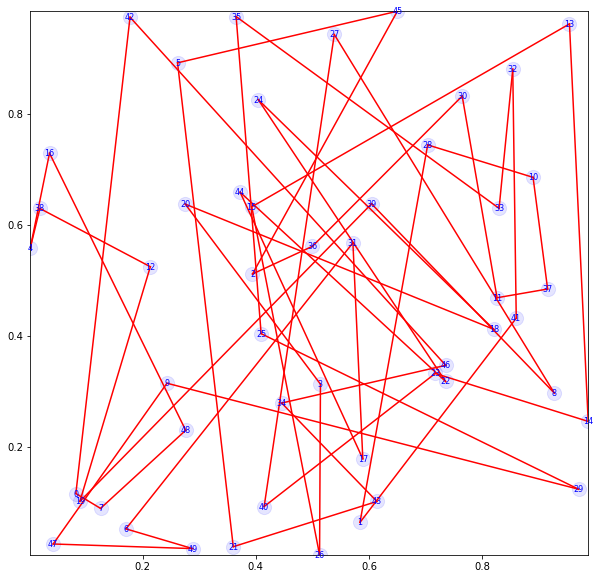

In [17]:
plot_solution(cities, dwave_leap_hybrid_route, "D-Wave Leap Hybrid Route")